In [1]:
import findspark
findspark.init('/home/ek/spark-2.4.4-bin-hadoop2.7')
import pyspark
import os
java8_location= '/usr/lib/jvm/java-8-openjdk-amd64' # Set your own
os.environ['JAVA_HOME'] = java8_location
from pyspark.sql.functions import udf
from IPython.display import Image
from pyspark.sql.types import (StructField,StringType,IntegerType,StructType)

In [2]:
from pyspark.sql import SparkSession

##### Start Spark session

In [3]:
spark = SparkSession.builder.appName('HW').getOrCreate()

In [4]:
spark.conf.set('spark.sql.shuffle.partitions',6)

###### Create my own user for the exercise 

In [5]:
artists = [1002470, 1000113, 1270, 1250104, 1000010, 3985, 1196, 2078915, 1000200, 4163, 1399]

preferences = []
for i,artist in enumerate(artists):
    if i >=7:
        preferences.append((12,artist,1))
    else:
        preferences.append((12,artist,150))

preferences_RDD = spark.sparkContext.parallelize(preferences)
data_schema = [StructField('userId',IntegerType(),True),
               StructField('artistId',IntegerType(),True),
              StructField('rating',IntegerType(),True)]
preferences_DF = preferences_RDD.toDF(StructType(data_schema))

preferences_DF.show()

+------+--------+------+
|userId|artistId|rating|
+------+--------+------+
|    12| 1002470|   150|
|    12| 1000113|   150|
|    12|    1270|   150|
|    12| 1250104|   150|
|    12| 1000010|   150|
|    12|    3985|   150|
|    12|    1196|   150|
|    12| 2078915|     1|
|    12| 1000200|     1|
|    12|    4163|     1|
|    12|    1399|     1|
+------+--------+------+



##### Load the data

In [6]:
data_df = spark.read.csv('dataset-problemset2-ex5/user_artist_data_small.txt',
                        sep = ' ',
                        inferSchema = True)

In [7]:
data_df = data_df.withColumnRenamed('_c0','userId')\
                 .withColumnRenamed('_c1','artistId')\
                 .withColumnRenamed('_c2','rating')

In [8]:
data_df.count()

49481

In [9]:
data_df.show(5)

+-------+--------+------+
| userId|artistId|rating|
+-------+--------+------+
|1059637| 1000010|   238|
|1059637| 1000049|     1|
|1059637| 1000056|     1|
|1059637| 1000062|    11|
|1059637| 1000094|     1|
+-------+--------+------+
only showing top 5 rows



In [10]:
data_df = data_df.union(preferences_DF)

In [11]:
correct_artists_df = spark.read.csv('dataset-problemset2-ex5/artist_alias_small.txt',
                        sep = '\t',
                        inferSchema = True)

In [12]:
correct_artists_df = correct_artists_df.withColumnRenamed('_c0','falseId')\
                     .withColumnRenamed('_c1','correctId')

In [13]:
correct_artists_df.show(5)

+-------+---------+
|falseId|correctId|
+-------+---------+
|1027859|  1252408|
|1017615|      668|
|6745885|  1268522|
|1018110|  1018110|
|1014609|  1014609|
+-------+---------+
only showing top 5 rows



In [14]:
correct_artists_df.createOrReplaceTempView('correct_artists')

In [15]:
data_df.createOrReplaceTempView('full_data')

##### Preprocess the data

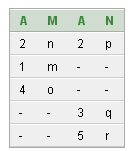

In [16]:
Image(filename='Downloads/foj.png')

We need to carry out a full outer join on the falseId column of the correct_artists table and the artistId column of the full_data table in order not to lose information but still match the relevant rows

In [17]:
joined_df = spark.sql("""SELECT * FROM full_data
                         FULL OUTER JOIN correct_artists 
                         ON correct_artists.falseId == full_data.artistId""")

In [18]:
joined_df.show(5)

+-------+--------+------+-------+---------+
| userId|artistId|rating|falseId|correctId|
+-------+--------+------+-------+---------+
|1059637|       2|     3|   null|     null|
|1046559|       2|   155|   null|     null|
|1031009|       2|   436|   null|     null|
|2020513|       2|   846|   null|     null|
|1001440|       2|  1541|   null|     null|
+-------+--------+------+-------+---------+
only showing top 5 rows



In [19]:
joined_df.count()

49492

Updating row values is not implemented in pyspark so we need to create a new column which holds the info we need : namely the correct artistId. To create this column we need to define a UDF which will return the values of the correctId column if they are not null and the values of the current artistId column where the correctId is null

In [20]:
def swap_values_udf(correct,false):
    if correct==None:
        return false
    else:
        return correct

In [21]:
swap_udf = udf(swap_values_udf)

In [22]:
joined_df = joined_df.withColumn('swapped',swap_udf(joined_df['correctId'],joined_df['artistId']))

In [23]:
joined_df.show(5) # make sure the function does what we want it to do

+-------+--------+------+-------+---------+-------+
| userId|artistId|rating|falseId|correctId|swapped|
+-------+--------+------+-------+---------+-------+
|1059637|       2|     3|   null|     null|      2|
|1046559|       2|   155|   null|     null|      2|
|1031009|       2|   436|   null|     null|      2|
|2020513|       2|   846|   null|     null|      2|
|1001440|       2|  1541|   null|     null|      2|
+-------+--------+------+-------+---------+-------+
only showing top 5 rows



In [24]:
dataset_df = joined_df.select(['userId','rating','swapped']).withColumnRenamed('swapped','artistId')

In [25]:
dataset_df.show(5)

+-------+------+--------+
| userId|rating|artistId|
+-------+------+--------+
|1059637|     3|       2|
|1046559|   155|       2|
|1031009|   436|       2|
|2020513|   846|       2|
|1001440|  1541|       2|
+-------+------+--------+
only showing top 5 rows



In [26]:
dataset_df.count()

49492

In [27]:
data_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- artistId: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [28]:
dataset_df.createOrReplaceTempView('dds')

take care of the repetitions by summing the ratings where the artistIds are equal

In [29]:
spark.sql('select * from dds where userId == 1007308 and artistId==1034635').show(1000)

+-------+------+--------+
| userId|rating|artistId|
+-------+------+--------+
|1007308|    72| 1034635|
|1007308|   187| 1034635|
+-------+------+--------+



In [30]:
spark.sql('select * from (select userId, artistId,sum(rating) from dds where group by userId,artistId) as b where b.userId == 1007308 and b.artistId==1034635').show(1000)

+-------+--------+-----------+
| userId|artistId|sum(rating)|
+-------+--------+-----------+
|1007308| 1034635|        259|
+-------+--------+-----------+



##### End of Preprocessing : dataset_df is the final preprocessed dataset 

In [31]:
dataset_df = spark.sql('select * from (select userId, artistId,sum(rating) as rating from dds where group by userId,artistId) as b').persist()

In [32]:
dataset_df.show(3)

+-------+--------+------+
| userId|artistId|rating|
+-------+--------+------+
|1059637|       2|     3|
|1070641|       2|   115|
|1052054|       2|   416|
+-------+--------+------+
only showing top 3 rows



In [33]:
dataset_df.rdd.getNumPartitions()

6

In [34]:
dataset_df.createOrReplaceTempView('dataset_df')

### Colaborative Filtering

In [35]:
dataset_avg = dataset_df.select(['userId','rating']).groupBy('userId').agg({'rating':'avg'}).persist()

In [36]:
dataset_avg.show(5)

+-------+------------------+
| userId|       avg(rating)|
+-------+------------------+
|2070757| 528.3850574712644|
|2288164| 319.7368421052632|
|1058890|160.91013071895424|
|1007308|203.18032786885246|
|1059334|13.781849315068493|
+-------+------------------+
only showing top 5 rows



In [37]:
dataset_final_df = dataset_df.join(dataset_avg, on = 'userId')

In [38]:
dataset_final_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- artistId: string (nullable = true)
 |-- rating: long (nullable = true)
 |-- avg(rating): double (nullable = true)



In [39]:
dataset_final_df.show(5)

+-------+--------+------+------------------+
| userId|artistId|rating|       avg(rating)|
+-------+--------+------+------------------+
|1059637|       2|     3|1878.5849582172702|
|1070641|       2|   115|103.90555555555555|
|1052054|       2|   416| 182.6338028169014|
|1046559|      18|    21|172.25842696629215|
|1059245|      18|     1| 79.32122213047069|
+-------+--------+------+------------------+
only showing top 5 rows



In [40]:
dataset_final_df.count() # as we see now we have less rows : because there are no duplicates

48954

In [41]:
dataset_final_df=dataset_final_df.na.drop()

In [42]:
dataset_final_df = dataset_final_df.withColumn('new',dataset_final_df['artistId'].cast('int'))\
                .drop('artistId')\
                .withColumnRenamed('new','artistId')

In [43]:
dataset_final_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- rating: long (nullable = true)
 |-- avg(rating): double (nullable = true)
 |-- artistId: integer (nullable = true)



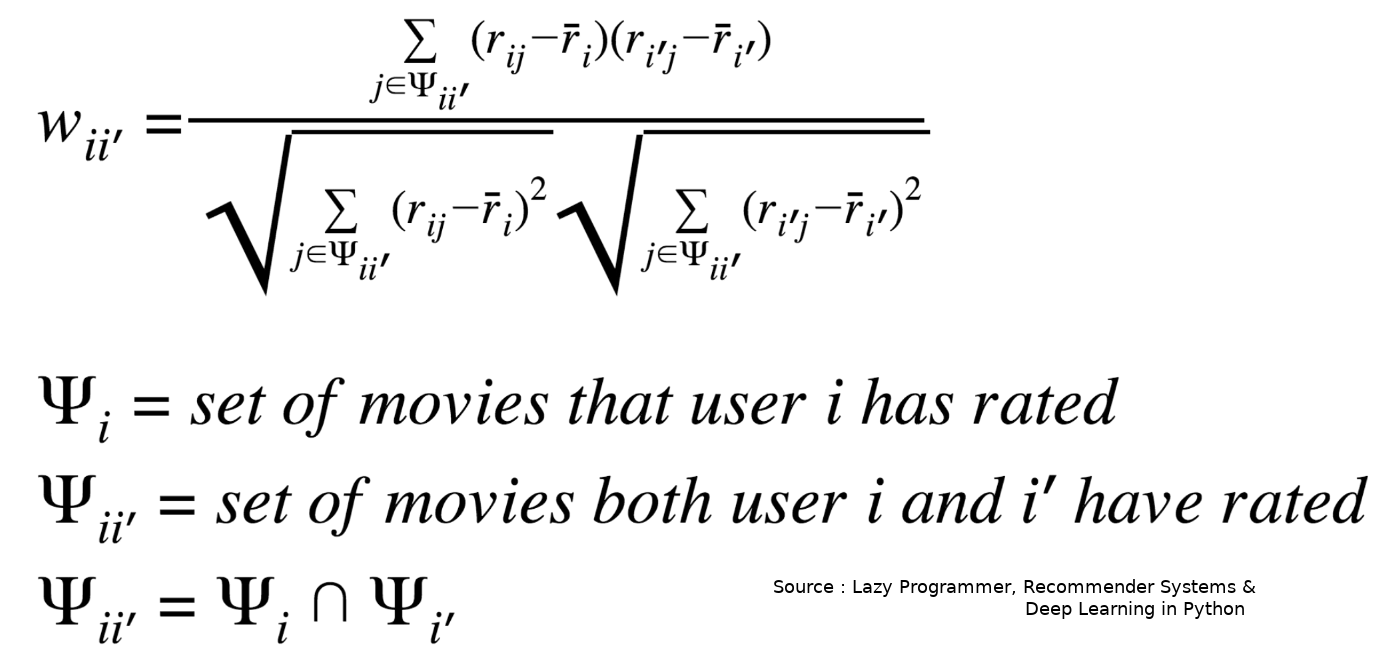

In [44]:
Image(filename='Pictures/calculating_weights.png')

##### Center the data

In [45]:
dataset_final_df = dataset_final_df.withColumn('centered_rating'
                            ,dataset_final_df['rating']-dataset_final_df['avg(rating)'])
                            

In [46]:
dataset_final_df.show(5)

+-------+------+------------------+--------+-------------------+
| userId|rating|       avg(rating)|artistId|    centered_rating|
+-------+------+------------------+--------+-------------------+
|1059637|     3|1878.5849582172702|       2|-1875.5849582172702|
|1070641|   115|103.90555555555555|       2| 11.094444444444449|
|1052054|   416| 182.6338028169014|       2|  233.3661971830986|
|1046559|    21|172.25842696629215|      18|-151.25842696629215|
|1059245|     1| 79.32122213047069|      18| -78.32122213047069|
+-------+------+------------------+--------+-------------------+
only showing top 5 rows



In [47]:
check_df = dataset_final_df

In [48]:
dataset_final_df.count()

48954

In [49]:
dataset_final_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- rating: long (nullable = true)
 |-- avg(rating): double (nullable = true)
 |-- artistId: integer (nullable = true)
 |-- centered_rating: double (nullable = true)



In [50]:
dataset_final_df = dataset_final_df.drop('rating')\
                      .withColumnRenamed('avg(rating)','avg_rating')\
                      .join(dataset_final_df\
                      .drop('rating')\
                      .withColumnRenamed('centered_rating','centered_rating2')
                      .withColumnRenamed('userId','userId2')
                      .withColumnRenamed('avg(rating)','avg_rating2')
                      ,on = 'artistId').filter('userId!=userId2').persist()

In [51]:
dataset_final_df.printSchema()

root
 |-- artistId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- centered_rating: double (nullable = true)
 |-- userId2: integer (nullable = true)
 |-- avg_rating2: double (nullable = true)
 |-- centered_rating2: double (nullable = true)



In [52]:
dataset_final_df.createOrReplaceTempView('dataset')

#### Normalize the data

Normalize the ratings for each user-user pair. Divide the centered_ratings for each user-user pair by the magnitude of the vector for that user-user pair. The normalized_U1 field holds the normalized ratings of userId. We have to implement simple matrix multiplication for those pairs.

In [53]:
dataset_final_df = spark.sql('''SELECT artistId, userId,  userId2_l,
             centered_rating/magnitude1 AS normalized_U1,
             centered_rating2/magnitude2 AS normalized_U2
             FROM 
             (SELECT           userId,
                               artistId, 
                               userId2,
                               centered_rating,
                               centered_rating2
                               FROM dataset) AS dataset 
             INNER JOIN 
             -- calculate magnitude of the utility matrix row for each user-user pair
             (SELECT           userId as userId_l, 
                               userId2 as userId2_l, 
                               SQRT(SUM(POWER(centered_rating,2))) AS magnitude1,
                               SQRT(SUM(POWER(centered_rating2,2))) AS magnitude2 
                               FROM dataset group BY userId,userId2)
             AS lengths 
              ON (dataset.userId==lengths.userId_l and dataset.userId2==lengths.userId2_l)''').persist() # normalize the vector elements for each user by dividing them by the length of the vector

In [54]:
dataset_final_df.show(5)

+--------+------+---------+-------------------+--------------------+
|artistId|userId|userId2_l|      normalized_U1|       normalized_U2|
+--------+------+---------+-------------------+--------------------+
|    4163|    12|  1009943|-0.7777777777777777|  -0.717082557479818|
| 1000010|    12|  1009943| 0.4444444444444444|-0.49284511043440593|
|    1270|    12|  1009943| 0.4444444444444444|-0.49284511043440593|
|    1270|    12|  1021501|                1.0|                -1.0|
| 1000113|    12|  1026084| 0.3321819194149599|  0.9842955983529055|
+--------+------+---------+-------------------+--------------------+
only showing top 5 rows



In [55]:
dataset_final_df.createOrReplaceTempView('dataset')

#### Calculate Pearson correlation
cary out vector multiplication based on each user-user pair (pairwize multiplication and sum)

In [56]:
cosine_similarities = spark.sql("""SELECT
                                  userId, 
                                  userId2_l AS userId2, 
                                  SUM(normalized_U1*normalized_U2) AS pearson_correlation 
                                  FROM dataset GROUP BY userId,userId2_l""").persist()

In [57]:
cosine_similarities.show(5)

+------+-------+-------------------+
|userId|userId2|pearson_correlation|
+------+-------+-------------------+
|    12|1009943| 0.1196463354314975|
|    12|1021501|               -1.0|
|    12|1026084| 0.2828235518174722|
|    12|2023742|                1.0|
|    12|2023977|                1.0|
+------+-------+-------------------+
only showing top 5 rows



In [58]:
cosine_similarities.createOrReplaceTempView('cosine')

##### Get predictions

In [59]:
def most_similar(id_,k=25):
    most_similar_df = spark.sql('select userId2, pearson_correlation from cosine where userId =={} order by pearson_correlation desc limit({})'.format(id_,k))
    return most_similar_df

In [60]:
most_similar = most_similar(12,30)

In [61]:
most_similar.show()

+-------+-------------------+
|userId2|pearson_correlation|
+-------+-------------------+
|2023742|                1.0|
|2023977|                1.0|
|2030069|                1.0|
|2069337|                1.0|
|1059245| 0.9999056515736351|
|1076906| 0.9604127314111832|
|1035511| 0.7445086131260299|
|1017610| 0.7105055601087813|
|2014936| 0.6953649880396114|
|1000647|  0.640928211497134|
|1029563| 0.6227218445426362|
|1052461| 0.5378675946282395|
|1001440|0.49808371185376143|
|2062243| 0.4204621232853993|
|1031009|0.41696658260808805|
|2007381| 0.4065275670745998|
|1048402| 0.3854557829312444|
|2070757|  0.349927750626236|
|1024631| 0.3268411271274031|
|1041919| 0.3156273116879044|
+-------+-------------------+
only showing top 20 rows



1. get the most 30 most similar users

In [62]:
most_similar.createOrReplaceTempView('most_similar')

In [63]:
check_df.withColumnRenamed('avg(rating)','avg_rating').persist().createOrReplaceTempView('check_df')


2 Multiply each ot the k-nearest neighbors' ratings by the weight (cosine similarity) of that neighbor w.r.t. the user U 

In [64]:
most_similar_preferences = spark.sql('''select userId,
             artistId,
             pearson_correlation*centered_rating as weighted,
             pearson_correlation
             from check_df 
             inner join most_similar 
             on check_df.userId==most_similar.userId2''').persist() # get the preferences of the K most similar

In [65]:
most_similar_preferences.show(5)

+-------+--------+-------------------+-------------------+
| userId|artistId|           weighted|pearson_correlation|
+-------+--------+-------------------+-------------------+
|1059637|       2| -551.4271215023415|0.29400274249718283|
|1046559|      18|  -46.7640327819857|0.30916646245704404|
|1059245|      18|  -78.3138326464117| 0.9999056515736351|
|1024631|      45| -5.873321714025265| 0.3268411271274031|
|2023686|      59|0.34746586193662776|0.15053732131701886|
+-------+--------+-------------------+-------------------+
only showing top 5 rows



In [66]:
most_similar_preferences.createOrReplaceTempView('most_similar')

3 Get predictions for U but only where he has not already rated the artist

In [67]:
most_similar_preferences_personalized = spark.sql("""
select artistId,userId,userId_U,weighted,rating,pearson_correlation from most_similar
full outer join
(select userId as userId_U,rating, artistId as artistId_2 from check_df where userId=={}) as check_df
on most_similar.artistId==check_df.artistId_2
""".format(12))

In [68]:
most_similar_preferences_personalized.show(5)

+--------+-------+--------+-------------------+------+-------------------+
|artistId| userId|userId_U|           weighted|rating|pearson_correlation|
+--------+-------+--------+-------------------+------+-------------------+
|       2|1059637|    null| -551.4271215023415|  null|0.29400274249718283|
|       2|1026084|    null|  320.4510536178026|  null| 0.2828235518174722|
|       2|1041919|    null| 471.03768571542884|  null| 0.3156273116879044|
|       2|1001440|    null|  739.6336268828944|  null|0.49808371185376143|
|       2|1048402|    null|-37.822848700128354|  null| 0.3854557829312444|
+--------+-------+--------+-------------------+------+-------------------+
only showing top 5 rows



In [69]:
most_similar_preferences_personalized.createOrReplaceTempView('most_similar_personalized')

#### FINAL RECOMMENDATIONS FOR U (ordered)

In [70]:
spark.sql("""
(select artistId, sum(weighted)/sum(pearson_correlation) as centered_prediction, sum(pearson_correlation)
from most_similar_personalized
where userId_U is null
group by artistId)
order by centered_prediction desc
""").show(5)

+--------+-------------------+------------------------+
|artistId|centered_prediction|sum(pearson_correlation)|
+--------+-------------------+------------------------+
| 6901343| 25902.816711590298|      0.4204621232853993|
| 1002095|  23077.64339098501|       5.509783070443343|
| 1000156| 14520.110586139623|      1.7682673686022778|
|    2823| 10804.158245019164|      4.6778954099173395|
| 1026440|  10338.37871036022|       4.600760757335854|
+--------+-------------------+------------------------+
only showing top 5 rows



It predicted some rock singers and it actually got a group I like in the predictions!!! (to my utter surprize) 
1026440	My Chemical Romance